# Focussed Analysis

The purpose of this notebook is to refine the exploratory analysis and create a more pointed analysis that answers the following exploratory questions more concisely:

1. How has the frequency of rain events changed year over year?
2. How has the frequency of weekly rain events changed year over year?

## Libraries

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline
plt.style.use('fivethirtyeight')

## Data

In [30]:
df = pd.read_csv('../data/processed/daily-weather-data.csv', parse_dates=['date'])
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3407 entries, 0 to 3406
Data columns (total 9 columns):
date             3407 non-null datetime64[ns]
totalPrecipMM    3361 non-null float64
minTemp          3407 non-null float64
maxTemp          3406 non-null float64
meanTemp         3406 non-null float64
totalSnowCM      1109 non-null float64
season           3407 non-null object
year             3407 non-null int64
month            3407 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(2), object(1)
memory usage: 239.6+ KB
None


,date,totalPrecipMM,minTemp,maxTemp,meanTemp,totalSnowCM,season,year,month
0,2010-01-01,4.9,-9.2,0.0,-4.6,15.0,winter,2010,1
1,2010-01-02,4.1,-14.1,-9.2,-11.7,6.0,winter,2010,1
2,2010-01-03,1.1,-12.6,-5.6,-9.1,1.0,winter,2010,1
3,2010-01-04,0.5,-11.2,-7.5,-9.4,1.0,winter,2010,1
4,2010-01-05,0.0,-8.9,-3.5,-6.2,NaN,winter,2010,1


We need to add a day column and remove days with an observed temperature below zero, making a strong assumption that it did not snow on those days.

In [33]:
# Set the threshold based on [1]
RAIN_DAY_THRESHOLD = 0.2

# Add day
df['day'] = df['date'].dt.day

# Remove days with low below zero
df = df.query('maxTemp >= 0')

# Rainy event indicator
df['rainEvent'] = df['totalPrecipMM'] >= RAIN_DAY_THRESHOLD

In [95]:
today = datetime.now().date()
month, day, year = today.month, today.day, today.year

## Exploratory Questions

### 1. How has the frequency of rain events changed year over year?

#### a. YTD

In [90]:
df_ytd = df.query(f'year <= {year} & month <= {month}')

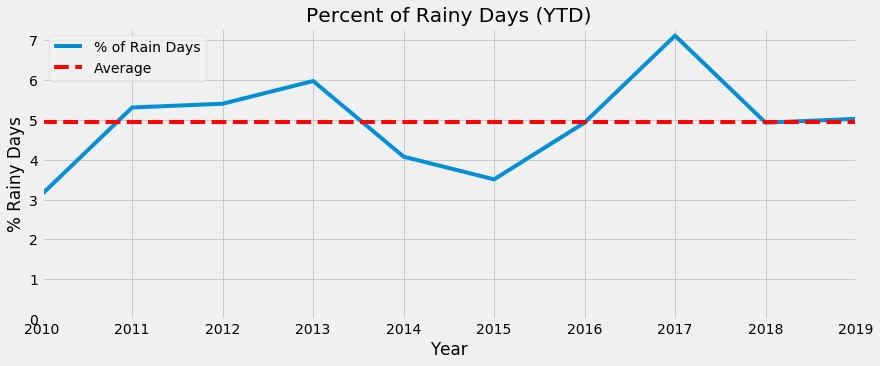

In [118]:
prop_rain_by_year_ytd = df_ytd.query('rainEvent').groupby('year').size() / len(df_ytd) * 100
mean_prop_rain_ytd = prop_rain_by_year_ytd.mean()

ax = prop_rain_by_year_ytd.rename('% of Rain Days').plot(figsize=(13,5))
ax.set(
  title='Percent of Rainy Days (YTD)',
  xlabel='Year',
  ylabel='% Rainy Days');
plt.axhline(mean_prop_rain_ytd, color='red', label='Average', linestyle='--');
plt.legend();
ax.set_ylim(bottom=0);

In [119]:
prop_rain_by_year[2017] / mean_prop_rain - 1

-0.4041968108666766

2017 saw a 48% increase in rain events compared to the mean over the period.

#### b. Full Year

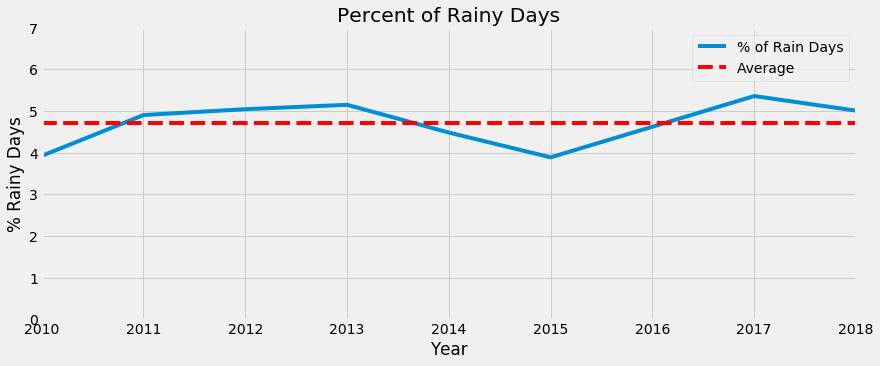

In [120]:
prop_rain_by_year = df.query(f'rainEvent & year < {year}').groupby('year').size() / len(df) * 100
mean_prop_rain = prop_rain_by_year.mean()

ax = prop_rain_by_year.rename('% of Rain Days').plot(figsize=(13,5))
ax.set(
  title='Percent of Rainy Days',
  xlabel='Year',
  ylabel='% Rainy Days');

plt.axhline(mean_prop_rain, color='red', label='Average', linestyle='--');
plt.legend();
ax.set_ylim(bottom=0, top=7);

2017 wasn't as extreme in the context of the full year but still had the most observed rain events.

### 2. How has the frequency of weekly rain events changed over time?

In [121]:
rainy_days_weekly = (
  df
    .query('rainEvent')
    .set_index('date')
    .resample('W-MON', label='left', closed='left')['totalPrecipMM']
    .agg(['count'])
    .rename(columns={'sum': 'totalPrecipMM', 'count': 'rainEvents'})
    .assign(date=lambda x: pd.to_datetime(x.index))
    .assign(year=lambda x: x.date.dt.year)
    .assign(month=lambda x: x.date.dt.month)
    .assign(day=lambda x: x.date.dt.day)
)
rainy_days_weekly.head()

,rainEvents,date,year,month,day
date,,,,,
2009-12-28,1,2009-12-28,2009,12,28
2010-01-04,0,2010-01-04,2010,1,4
2010-01-11,0,2010-01-11,2010,1,11
2010-01-18,1,2010-01-18,2010,1,18
2010-01-25,1,2010-01-25,2010,1,25


#### a. YTD

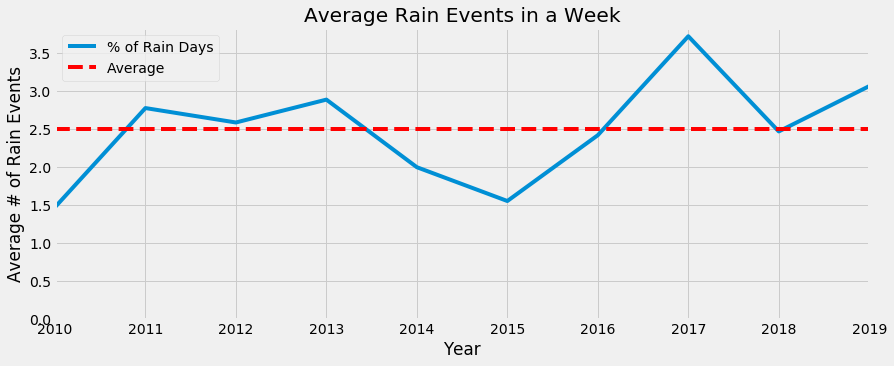

In [126]:
rainy_days_weekly_ytd = rainy_days_weekly.query(f'month <= {month} & day <= {day}')

weekly_prop_rain_by_year_ytd = rainy_days_weekly_ytd.groupby('year')['rainEvents'].mean()
weekly_mean_prop_rain_ytd = weekly_prop_rain_by_year_ytd.mean()

ax = weekly_prop_rain_by_year_ytd.rename('% of Rain Days').plot(figsize=(13,5))
ax.set(
  title='Average Rain Events in a Week',
  xlabel='Year',
  ylabel='Average # of Rain Events');
plt.axhline(weekly_mean_prop_rain_ytd, color='red', label='Average', linestyle='--');
plt.legend();
ax.set_ylim(bottom=0);

In [127]:
weekly_prop_rain_by_year_ytd[2017] / weekly_mean_prop_rain_ytd - 1

0.49099587583692417

2017 saw a 49% increase in rain events compared to the mean over the period - slightly higher than the difference of total rain event frequency.

#### b. Full Year

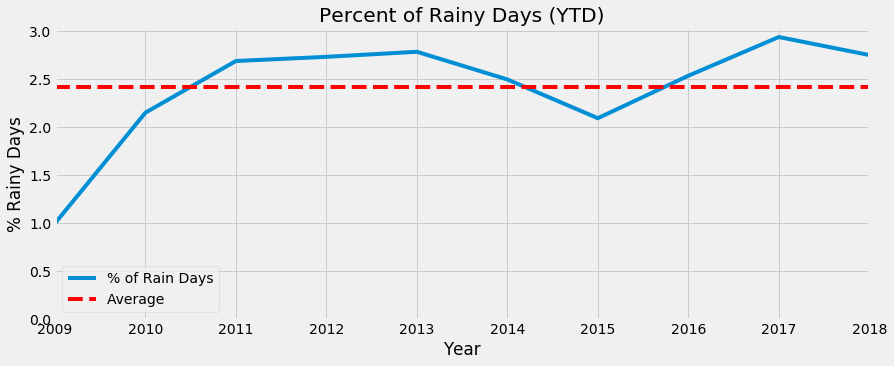

In [128]:
weekly_prop_rain_by_year = rainy_days_weekly.query(f'year < {year}').groupby('year')['rainEvents'].mean()
weekly_mean_prop_rain = weekly_prop_rain_by_year.mean()

ax = weekly_prop_rain_by_year.rename('% of Rain Days').plot(figsize=(13,5))
ax.set(
  title='Percent of Rainy Days (YTD)',
  xlabel='Year',
  ylabel='% Rainy Days');
plt.axhline(weekly_mean_prop_rain, color='red', label='Average', linestyle='--');
plt.legend();
ax.set_ylim(bottom=0);

In [132]:
weekly_prop_rain_by_year_ytd.std(), weekly_prop_rain_by_year.std()

(0.6874583734708017, 0.5683371151840176)

This series varies less than the YTD series, likely reflecting the higher rain frequency rain in the first quarter of the year (see previous notebook).

## Sources

[1] https://ec.gc.ca/meteo-weather/default.asp?lang=En&n=B8CD636F-1&def=show02B55773D#wsDT2B55773D